## Loading the dataset
After downloading the dataset from http://ufldl.stanford.edu/housenumbers/ in the second variant (32x32 images with a single number centered)

In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 450kB 57.9MB/s 
     |████████████████████████████████| 3.8MB 54.0MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np, random, os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json

#Read the datasets into memory
from scipy.io import loadmat

train = loadmat('drive/My Drive/Colab Notebooks/train_32x32.mat')
test = loadmat('drive/My Drive/Colab Notebooks/test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [0]:
#reshape the arrays to have the sample number as the first index

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [0]:
#label for 0 is 10, change to 0 the label for 0

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

### Convert from rgb to grayscale

In [0]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

In [0]:
train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

## Extract a random validation set from the training set
In this case the size of the validation set is 10% of the training set.  
It is randomly extracted because the order of the images in the training set it's not random: consecutive images are part of the same original image with a complete house number.

In [0]:
#Divide training and validation
#validation set size is 10% of training set
validation_percentage = 0.1
validation_size = int(validation_percentage * train_img.shape[0])
#select the validation set as a random sample from the training set
random.seed(0) #chosen seed so the set is always the same
sample = random.sample(range(train_img.shape[0]), validation_size)
validation_img = train_img[sample,:,:,:]
train_img = np.delete(train_img, sample, 0)
validation_lbs = train_lbs[sample,:]
train_lbs = np.delete(train_lbs, sample, 0)

train_img.shape, validation_img.shape, train_lbs.shape, validation_lbs.shape

((65932, 32, 32, 1), (7325, 32, 32, 1), (65932, 1), (7325, 1))

## Visualize the images

In [0]:
#Function to visualize image with their respective labels
def plot_img_grayscale(images, labels, rows=2, cols=8):
    plt.figure(figsize=(cols*2,rows*2))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,0], cmap='gray',vmin=0, vmax=255)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(labels[i][0])
    plt.show()

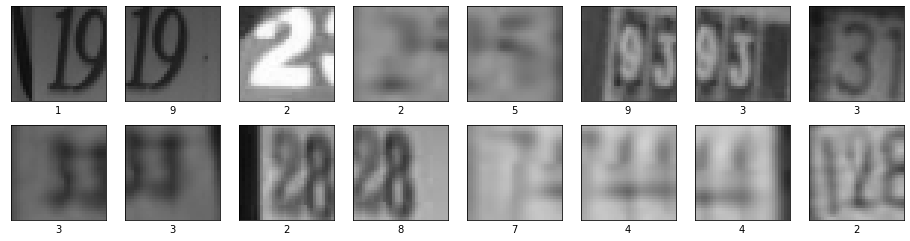

In [0]:
plot_img_grayscale(train_img, train_lbs)

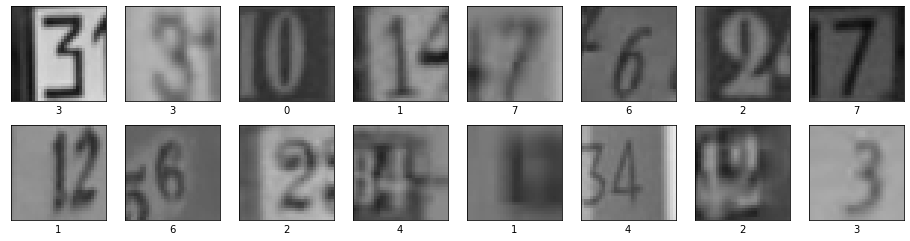

In [0]:
#Check if the validation set is divided correctely and print the data
plot_img_grayscale(validation_img, validation_lbs)

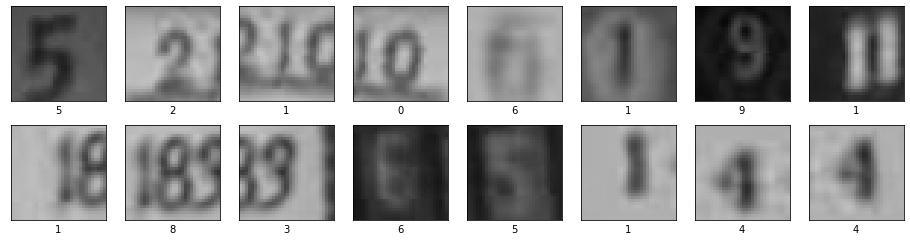

In [0]:
plot_img_grayscale(test_img, test_lbs)

## Data preprocessing

Two techniques are used in this order on the training set:

- **zero centering**: this is achieved by subctracting the mean of each colour channel (in this case just one beacuse the images are grayscaled) across said colour channel.
- **normalization**: divide each colour channel by its standard deviation (calculated after zero centering).

The same techniques are applied also on the validation set and test set but using the same parameters (mean and standard deviation) obtained from the training set.

In [0]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for validation and test set
validation_img = validation_img - train_mean
validation_img = validation_img / train_std
test_img = test_img - train_mean
test_img = test_img / train_std

## Hyper-parameters Optimization

In [0]:
##hyper parameters network structure, batch size, learning rate, drop-out

#do the train
#see what hyperparameters do better on val set
#redo the trainign with the best parameters on val set + train set
#evaluate on training set

#adapt network architecture:
#try max pool instead of stride or vice versa
#try global avarage pooling vs fully connected

In [0]:
#train on 6 epochs
EPOCH_NUM = 10

#default batch size
BATCH_SIZE = 128

#set to True to save checkpoints of the training
SAVE = False

#allows to save the weights for a model in a directory called dir_name
def checkpoint(dir_name):
    #make dir otherwise the checkpoint creation throws Exception
    os.makedirs(dir_name, exist_ok=True)
    return tf.keras.callbacks.ModelCheckpoint(filepath=dir_name+'/cp-{epoch:02d}.hd5', verbose=0, period=3)

#create multiple learning rates
def learning_rate(i):
    return tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * (0.8 - (0.033*i )) ** x, verbose=0)

def create_callbacks(dir_name, lr=0):
    cb = []
    if SAVE:
        cb.append(checkpoint(dir_name))
    cb.append(learning_rate(lr))
    return cb

In [0]:
#define function to plot accuracy or loss
def plot_validation(history, loss=False):
    number_of_models = len(history)
    if loss:
        name, key, loc, f = 'Loss', 'loss', 'lower left', min
    else:
        name, key, loc, f = 'Accuracy', 'accuracy', 'upper left', max
    plt.figure(figsize=(8,3))
    for i in range(number_of_models):
        plt.plot(history[i].history['val_'+key], label='val_'+key+str(i))
        print('CNN {0}: Epochs={1:d}, Train {2}={3:.5f}, Validation {2}={4:.5f}'.format(
            i,len(history[i].history[key]),name,f(history[i].history[key]),f(history[i].history['val_'+key])))
    plt.title('Validation '+ name)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend(loc='upper left')
    plt.show()

In [0]:
#funciton to get the index of the model with the best accuracy or loss
def get_best_model(history, loss=False):
    number_of_models = len(history)
    key, op = ('val_loss', min) if loss else ('val_accuracy', max)
    max_values = []
    for i in range(number_of_models):
        best_value = op([x for x in history[i].history[key]])
        max_values.append(best_value)
    return max_values.index(op(max_values))

In [0]:
#save the history from a list of trained models
def save_history(hist_list, path):
    if path != None:
        for i in range(len(hist_list)):
            #make dir otherwise file creation throws exception
            os.makedirs(path+str(i), exist_ok=True)
            json.dump(str(hist_list[i].history), open(path+str(i)+"/hist"+str(i)+".json", 'w'))
    
def load_history(path):
    return json.load(open(path, 'r'))

### Explain the basic structure on their hyper parameters
we are now going ot start hyperparameter evaluation

the basic network structure will be  
(conv2dLayer\* **N** (filterSize\* **L**) -> (maxPool or Stride))\***M** -> (FCnonlinear\***K** -> FCsoftmax) or (Global avarage pooling)

There are two typical architecture: conv layer followed by a max pooling or smaller conv layer followed by a conv layer with stride=2. Here the two are confronted giving each one roughly the same number of convolutional neurons.

### Validate the number of covolutional layers

In [0]:
val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 0:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    if i == 2 or i == 5:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i == 3 or i == 6:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/layers/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 4s 67us/sample - loss: 0.8284 - accuracy: 0.7495 - val_loss: 0.5257 - val_accuracy: 0.8558
Epoch 2/10
65932/65932 [==============================] - 4s 60us/sample - loss: 0.4608 - accuracy: 0.8704 - val_loss: 0.4743 - val_accuracy: 0.8627
Epoch 3/10
65932/65932 [==============================] - 4s 60us/sample - loss: 0.3786 - accuracy: 0.8914 - val_loss: 0.4114 - val_accuracy: 0.8799
Epoch 4/10
65932/65932 [==============================] - 4s 61us/sample - loss: 0.3266 - accuracy: 0.9065 - val_loss: 0.3962 - val_accuracy: 0.8841
Epoch 5/10
65932/65932 [==============================] - 4s 59us/sample - loss: 0.2882 - accuracy: 0.9178 - val_loss: 0.3834 - val_accuracy: 0.8867
Epoch 6/10
65932/65932 [==============================] - 4s 59us/sample - loss: 0.2571 - accuracy: 0.9272 - val_loss: 0.3864 - val_accuracy: 0.8897
Epoch 7/10
65932/65932 [==============================] -

CNN 0: Epochs=10, Train Accuracy=0.94933, Validation Accuracy=0.89270
CNN 1: Epochs=10, Train Accuracy=0.98415, Validation Accuracy=0.91263
CNN 2: Epochs=10, Train Accuracy=0.99048, Validation Accuracy=0.91768
CNN 3: Epochs=10, Train Accuracy=0.99788, Validation Accuracy=0.92191
CNN 4: Epochs=10, Train Accuracy=0.98957, Validation Accuracy=0.91713
CNN 5: Epochs=10, Train Accuracy=0.98392, Validation Accuracy=0.92205
CNN 6: Epochs=10, Train Accuracy=0.99914, Validation Accuracy=0.91782


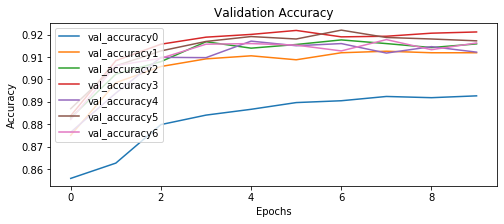

CNN 0: Epochs=10, Train Loss=0.18531, Validation Loss=0.38170
CNN 1: Epochs=10, Train Loss=0.06943, Validation Loss=0.30781
CNN 2: Epochs=10, Train Loss=0.04133, Validation Loss=0.28275
CNN 3: Epochs=10, Train Loss=0.01170, Validation Loss=0.28666
CNN 4: Epochs=10, Train Loss=0.04805, Validation Loss=0.30348
CNN 5: Epochs=10, Train Loss=0.06503, Validation Loss=0.27967
CNN 6: Epochs=10, Train Loss=0.00432, Validation Loss=0.29656


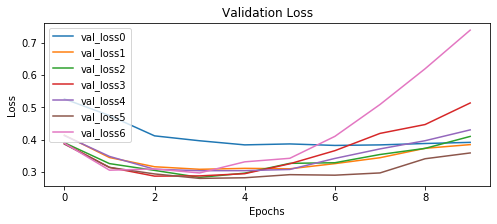

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 5 is the best one
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_63 (Conv2D)    

### Validate max-pool over stride2

In [0]:
val_models = []

models_number = 2
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i == 0:
        model.add(layers.MaxPooling2D())
    else:
        model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i ==0:
        model.add(layers.MaxPooling2D())
    else:
        model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/stride/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 7s 101us/sample - loss: 0.8197 - accuracy: 0.7315 - val_loss: 0.4269 - val_accuracy: 0.8663
Epoch 2/10
65932/65932 [==============================] - 6s 92us/sample - loss: 0.3436 - accuracy: 0.8970 - val_loss: 0.3441 - val_accuracy: 0.8994
Epoch 3/10
65932/65932 [==============================] - 6s 95us/sample - loss: 0.2696 - accuracy: 0.9210 - val_loss: 0.3101 - val_accuracy: 0.9104
Epoch 4/10
65932/65932 [==============================] - 6s 92us/sample - loss: 0.2250 - accuracy: 0.9336 - val_loss: 0.2931 - val_accuracy: 0.9137
Epoch 5/10
65932/65932 [==============================] - 6s 92us/sample - loss: 0.1895 - accuracy: 0.9449 - val_loss: 0.2798 - val_accuracy: 0.9193
Epoch 6/10
65932/65932 [==============================] - 6s 92us/sample - loss: 0.1587 - accuracy: 0.9548 - val_loss: 0.2877 - val_accuracy: 0.9208
Epoch 7/10
65932/65932 [==============================] 

CNN 0: Epochs=10, Train Accuracy=0.98218, Validation Accuracy=0.92082
CNN 1: Epochs=10, Train Accuracy=0.98881, Validation Accuracy=0.91986


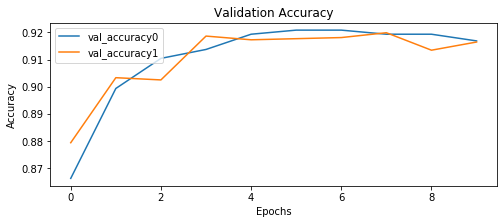

CNN 0: Epochs=10, Train Loss=0.07101, Validation Loss=0.27978
CNN 1: Epochs=10, Train Loss=0.04557, Validation Loss=0.28261


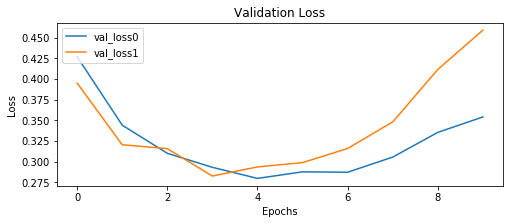

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 0 is the best one
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_93 (Conv2D)    

### Validate the number of filters per layer

In [0]:
val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32+8*i, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(32+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(64+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(48+8*i, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/filters/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 10s 148us/sample - loss: 0.7799 - accuracy: 0.7477 - val_loss: 0.4212 - val_accuracy: 0.8777
Epoch 2/10
65932/65932 [==============================] - 9s 137us/sample - loss: 0.3074 - accuracy: 0.9089 - val_loss: 0.2906 - val_accuracy: 0.9125
Epoch 3/10
65932/65932 [==============================] - 9s 139us/sample - loss: 0.2318 - accuracy: 0.9328 - val_loss: 0.2681 - val_accuracy: 0.9218
Epoch 4/10
65932/65932 [==============================] - 9s 139us/sample - loss: 0.1868 - accuracy: 0.9460 - val_loss: 0.2650 - val_accuracy: 0.9208
Epoch 5/10
65932/65932 [==============================] - 9s 139us/sample - loss: 0.1496 - accuracy: 0.9577 - val_loss: 0.2504 - val_accuracy: 0.9259
Epoch 6/10
65932/65932 [==============================] - 9s 141us/sample - loss: 0.1137 - accuracy: 0.9680 - val_loss: 0.2675 - val_accuracy: 0.9282
Epoch 7/10
65932/65932 [==========================

CNN 0: Epochs=10, Train Accuracy=0.99422, Validation Accuracy=0.92819
CNN 1: Epochs=10, Train Accuracy=0.99867, Validation Accuracy=0.93201
CNN 2: Epochs=10, Train Accuracy=0.99712, Validation Accuracy=0.92669
CNN 3: Epochs=10, Train Accuracy=0.99915, Validation Accuracy=0.93379
CNN 4: Epochs=10, Train Accuracy=0.99885, Validation Accuracy=0.93092
CNN 5: Epochs=10, Train Accuracy=0.99873, Validation Accuracy=0.93324
CNN 6: Epochs=10, Train Accuracy=0.99507, Validation Accuracy=0.93051


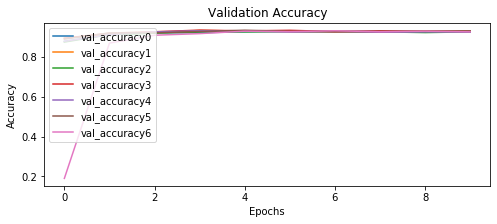

CNN 0: Epochs=10, Train Loss=0.02381, Validation Loss=0.25045
CNN 1: Epochs=10, Train Loss=0.00601, Validation Loss=0.24442
CNN 2: Epochs=10, Train Loss=0.01351, Validation Loss=0.24887
CNN 3: Epochs=10, Train Loss=0.00399, Validation Loss=0.23812
CNN 4: Epochs=10, Train Loss=0.00581, Validation Loss=0.24814
CNN 5: Epochs=10, Train Loss=0.00481, Validation Loss=0.24692
CNN 6: Epochs=10, Train Loss=0.02196, Validation Loss=0.24546


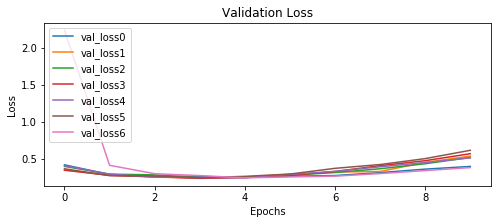

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 3 is the best one
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_209 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_214 (Conv2D)   

In [0]:
#first layer weights
FLK = 32+8*best
#second layer weights
SLK = 64+16*best
#third layer weights
TLK = 48+8*best

### Validate the number neurons in the fully connected layer and a second fc layer

In [0]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu'))
    
    model.add(layers.Flatten())
    if i >= 3:
        model.add(layers.Dense(96+32*(i-3), activation='relu'))
        model.add(layers.Dense(64+32*(i-3), activation='relu'))
    else:
        model.add(layers.Dense(96+32*i, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/fully_connected/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 17s 253us/sample - loss: 0.9050 - accuracy: 0.7011 - val_loss: 0.3628 - val_accuracy: 0.8887
Epoch 2/10
65932/65932 [==============================] - 16s 247us/sample - loss: 0.2990 - accuracy: 0.9118 - val_loss: 0.3087 - val_accuracy: 0.9126
Epoch 3/10
65932/65932 [==============================] - 16s 248us/sample - loss: 0.2266 - accuracy: 0.9350 - val_loss: 0.2787 - val_accuracy: 0.9204
Epoch 4/10
65932/65932 [==============================] - 16s 247us/sample - loss: 0.1808 - accuracy: 0.9487 - val_loss: 0.2586 - val_accuracy: 0.9282
Epoch 5/10
65932/65932 [==============================] - 16s 245us/sample - loss: 0.1416 - accuracy: 0.9604 - val_loss: 0.2578 - val_accuracy: 0.9309
Epoch 6/10
65932/65932 [==============================] - 16s 245us/sample - loss: 0.1063 - accuracy: 0.9705 - val_loss: 0.2553 - val_accuracy: 0.9282
Epoch 7/10
65932/65932 [=====================

CNN 0: Epochs=10, Train Accuracy=0.99606, Validation Accuracy=0.93092
CNN 1: Epochs=10, Train Accuracy=0.99795, Validation Accuracy=0.93488
CNN 2: Epochs=10, Train Accuracy=0.99813, Validation Accuracy=0.93065
CNN 3: Epochs=10, Train Accuracy=0.99769, Validation Accuracy=0.93201
CNN 4: Epochs=10, Train Accuracy=0.99669, Validation Accuracy=0.93215
CNN 5: Epochs=10, Train Accuracy=0.99820, Validation Accuracy=0.93229


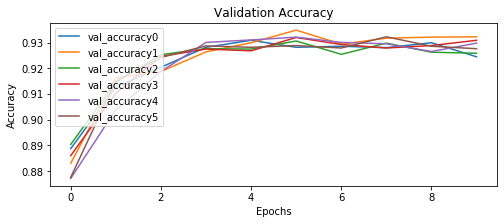

CNN 0: Epochs=10, Train Loss=0.01733, Validation Loss=0.25526
CNN 1: Epochs=10, Train Loss=0.00916, Validation Loss=0.25299
CNN 2: Epochs=10, Train Loss=0.00736, Validation Loss=0.25047
CNN 3: Epochs=10, Train Loss=0.01025, Validation Loss=0.25067
CNN 4: Epochs=10, Train Loss=0.01253, Validation Loss=0.23973
CNN 5: Epochs=10, Train Loss=0.00801, Validation Loss=0.25664


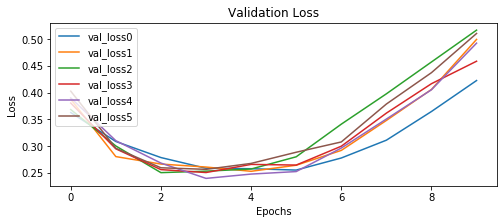

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 4 is the best one
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_307 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_308 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_309 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_310 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_311 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_312 (Conv2D)   

In [0]:
#fully connected layer weights
FDL = 96+32*(best-3)
SDL = 64+32*(best-3)

### Validate the batch size

In [0]:
val_models = []

batch_base = 24
batch_increment = 24

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(FDL, activation='relu'))
    model.add(layers.Dense(SDL, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/batch/var'


for i in range(models_number):
    #adjusted batch size
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch_base + (i*batch_increment), epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 23s 352us/sample - loss: 0.6738 - accuracy: 0.7823 - val_loss: 0.3504 - val_accuracy: 0.8957
Epoch 2/10
65932/65932 [==============================] - 23s 344us/sample - loss: 0.2887 - accuracy: 0.9153 - val_loss: 0.2968 - val_accuracy: 0.9111
Epoch 3/10
65932/65932 [==============================] - 23s 344us/sample - loss: 0.2201 - accuracy: 0.9365 - val_loss: 0.2791 - val_accuracy: 0.9177
Epoch 4/10
65932/65932 [==============================] - 23s 343us/sample - loss: 0.1667 - accuracy: 0.9521 - val_loss: 0.2664 - val_accuracy: 0.9264
Epoch 5/10
65932/65932 [==============================] - 23s 344us/sample - loss: 0.1179 - accuracy: 0.9666 - val_loss: 0.2831 - val_accuracy: 0.9272
Epoch 6/10
65932/65932 [==============================] - 23s 350us/sample - loss: 0.0785 - accuracy: 0.9770 - val_loss: 0.2882 - val_accuracy: 0.9298
Epoch 7/10
65932/65932 [=====================

CNN 0: Epochs=10, Train Accuracy=0.99792, Validation Accuracy=0.93174
CNN 1: Epochs=10, Train Accuracy=0.99756, Validation Accuracy=0.93324
CNN 2: Epochs=10, Train Accuracy=0.99757, Validation Accuracy=0.93311
CNN 3: Epochs=10, Train Accuracy=0.99706, Validation Accuracy=0.93311
CNN 4: Epochs=10, Train Accuracy=0.99618, Validation Accuracy=0.93338
CNN 5: Epochs=10, Train Accuracy=0.99198, Validation Accuracy=0.93324


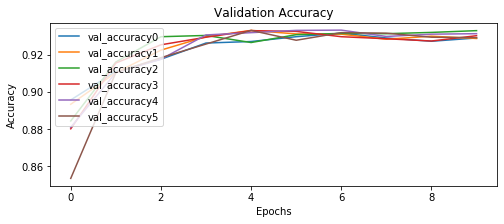

CNN 0: Epochs=10, Train Loss=0.00694, Validation Loss=0.26636
CNN 1: Epochs=10, Train Loss=0.00865, Validation Loss=0.25164
CNN 2: Epochs=10, Train Loss=0.01042, Validation Loss=0.23521
CNN 3: Epochs=10, Train Loss=0.01242, Validation Loss=0.23770
CNN 4: Epochs=10, Train Loss=0.01573, Validation Loss=0.24238
CNN 5: Epochs=10, Train Loss=0.03464, Validation Loss=0.23446


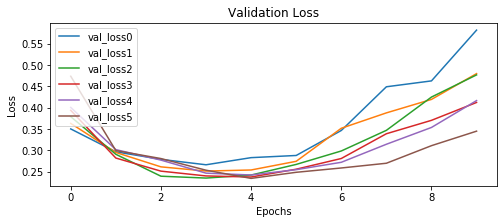

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 5 is the best one
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_440 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_441 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_442 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_443 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_444 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_445 (Conv2D)   

In [0]:
BEST_BATCH_SIZE = batch_base+best*(batch_increment)

### Validate Learning rate

In [0]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(FDL, activation='relu'))
    model.add(layers.Dense(SDL, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/learning_rate/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BEST_BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i), lr=i)))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 17s 253us/sample - loss: 0.9689 - accuracy: 0.6744 - val_loss: 0.4012 - val_accuracy: 0.8830
Epoch 2/10
65932/65932 [==============================] - 16s 246us/sample - loss: 0.3088 - accuracy: 0.9082 - val_loss: 0.2832 - val_accuracy: 0.9160
Epoch 3/10
65932/65932 [==============================] - 16s 250us/sample - loss: 0.2289 - accuracy: 0.9335 - val_loss: 0.2517 - val_accuracy: 0.9285
Epoch 4/10
65932/65932 [==============================] - 17s 251us/sample - loss: 0.1788 - accuracy: 0.9485 - val_loss: 0.2665 - val_accuracy: 0.9240
Epoch 5/10
65932/65932 [==============================] - 16s 250us/sample - loss: 0.1387 - accuracy: 0.9614 - val_loss: 0.2585 - val_accuracy: 0.9291
Epoch 6/10
65932/65932 [==============================] - 16s 249us/sample - loss: 0.1006 - accuracy: 0.9723 - val_loss: 0.2681 - val_accuracy: 0.9326
Epoch 7/10
65932/65932 [=====================

CNN 0: Epochs=10, Train Accuracy=0.99638, Validation Accuracy=0.93256
CNN 1: Epochs=10, Train Accuracy=0.99768, Validation Accuracy=0.93392
CNN 2: Epochs=10, Train Accuracy=0.99736, Validation Accuracy=0.92860
CNN 3: Epochs=10, Train Accuracy=0.99204, Validation Accuracy=0.93270
CNN 4: Epochs=10, Train Accuracy=0.99321, Validation Accuracy=0.93406
CNN 5: Epochs=10, Train Accuracy=0.98976, Validation Accuracy=0.93420


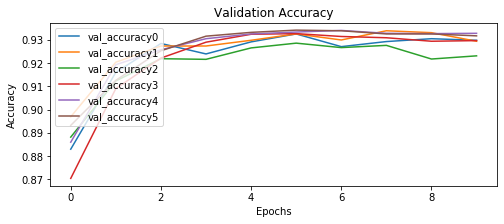

CNN 0: Epochs=10, Train Loss=0.01409, Validation Loss=0.25169
CNN 1: Epochs=10, Train Loss=0.01231, Validation Loss=0.24343
CNN 2: Epochs=10, Train Loss=0.01424, Validation Loss=0.26004
CNN 3: Epochs=10, Train Loss=0.03689, Validation Loss=0.23462
CNN 4: Epochs=10, Train Loss=0.03393, Validation Loss=0.24287
CNN 5: Epochs=10, Train Loss=0.04588, Validation Loss=0.24710


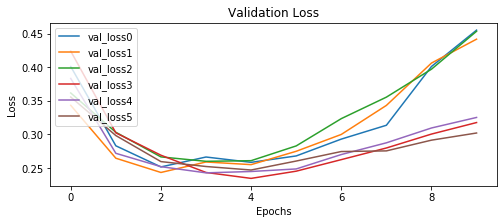

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 3 is the best one
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_468 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_469 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_470 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_471 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_472 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_473 (Conv2D)   

In [0]:
BEST_LR = lea

In [0]:
learning_rate(best)

### Validate droput

In [0]:
val_models = []

dropout = [0.1,0.2,0.3,0.4,0.5,0.6]

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dropout(dropout[i]))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/dropout/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i), lr=BEST_LR)))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 186s 3ms/sample - loss: 0.7821 - acc: 0.7470 - val_loss: 0.3659 - val_acc: 0.8930
Epoch 2/6
65932/65932 [==============================] - 183s 3ms/sample - loss: 0.3473 - acc: 0.8984 - val_loss: 0.3320 - val_acc: 0.8984
Epoch 3/6
65932/65932 [==============================] - 188s 3ms/sample - loss: 0.2814 - acc: 0.9172 - val_loss: 0.3044 - val_acc: 0.9089
Epoch 4/6
65932/65932 [==============================] - 188s 3ms/sample - loss: 0.2343 - acc: 0.9330 - val_loss: 0.3064 - val_acc: 0.9114
Epoch 5/6
65932/65932 [==============================] - 189s 3ms/sample - loss: 0.1986 - acc: 0.9420 - val_loss: 0.2742 - val_acc: 0.9200
Epoch 6/6
65932/65932 [==============================] - 187s 3ms/sample - loss: 0.1677 - acc: 0.9512 - val_loss: 0.3132 - val_acc: 0.9156
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 187s 3ms/sa

CNN 0: Epochs=6, Train Accuracy=0.95116, Validation Accuracy=0.92000
CNN 1: Epochs=6, Train Accuracy=0.94469, Validation Accuracy=0.92109
CNN 2: Epochs=6, Train Accuracy=0.93445, Validation Accuracy=0.91809
CNN 3: Epochs=6, Train Accuracy=0.92479, Validation Accuracy=0.91945
CNN 4: Epochs=6, Train Accuracy=0.92465, Validation Accuracy=0.92423
CNN 5: Epochs=6, Train Accuracy=0.90980, Validation Accuracy=0.92396


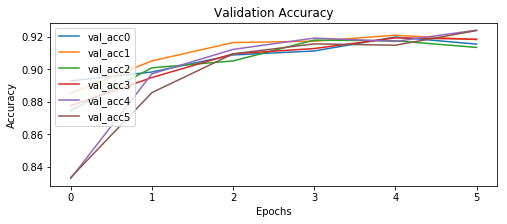

CNN 0: Epochs=6, Train Loss=0.16775, Validation Loss=0.27420
CNN 1: Epochs=6, Train Loss=0.19597, Validation Loss=0.27990
CNN 2: Epochs=6, Train Loss=0.22570, Validation Loss=0.29314
CNN 3: Epochs=6, Train Loss=0.26093, Validation Loss=0.28610
CNN 4: Epochs=6, Train Loss=0.26982, Validation Loss=0.27945
CNN 5: Epochs=6, Train Loss=0.32172, Validation Loss=0.28744


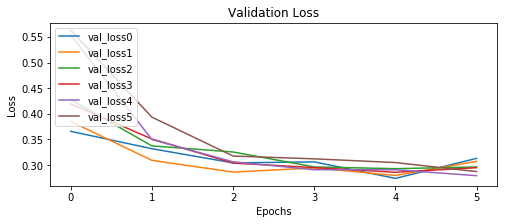

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 4 is the best one
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 32, 32, 40)        400       
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 15, 15, 40)        14440     
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 15, 15, 80)        28880     
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 15, 15, 80)        57680     
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 15, 15, 8

In [0]:
best_dropout = dropout[best]

### Validate L2 regularization

In [0]:
val_models = []

reg_factor = [0.00001,0.00005,0.0001,0.0005]

models_number = 4
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1),
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/l2_reg/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i), lr=BEST_LR)))

Train on 65932 samples, validate on 7325 samples
Epoch 1/11
65932/65932 [==============================] - 193s 3ms/sample - loss: 1.0123 - acc: 0.6621 - val_loss: 0.4668 - val_acc: 0.8564
Epoch 2/11
65932/65932 [==============================] - 192s 3ms/sample - loss: 0.3819 - acc: 0.8869 - val_loss: 0.3520 - val_acc: 0.8964
Epoch 3/11
65932/65932 [==============================] - 197s 3ms/sample - loss: 0.2959 - acc: 0.9151 - val_loss: 0.2975 - val_acc: 0.9134
Epoch 4/11
65932/65932 [==============================] - 202s 3ms/sample - loss: 0.2510 - acc: 0.9284 - val_loss: 0.2805 - val_acc: 0.9155
Epoch 5/11
65932/65932 [==============================] - 193s 3ms/sample - loss: 0.2211 - acc: 0.9383 - val_loss: 0.2880 - val_acc: 0.9180
Epoch 6/11
65932/65932 [==============================] - 196s 3ms/sample - loss: 0.1945 - acc: 0.9450 - val_loss: 0.3034 - val_acc: 0.9184
Epoch 7/11
30464/65932 [============>.................] - ETA: 1:41 - loss: 0.1568 - acc: 0.9560

KeyboardInterrupt: 

CNN 0: Epochs=6, Train Accuracy=0.95116, Validation Accuracy=0.92000
CNN 1: Epochs=6, Train Accuracy=0.94469, Validation Accuracy=0.92109
CNN 2: Epochs=6, Train Accuracy=0.93445, Validation Accuracy=0.91809
CNN 3: Epochs=6, Train Accuracy=0.92479, Validation Accuracy=0.91945
CNN 4: Epochs=6, Train Accuracy=0.92465, Validation Accuracy=0.92423
CNN 5: Epochs=6, Train Accuracy=0.90980, Validation Accuracy=0.92396


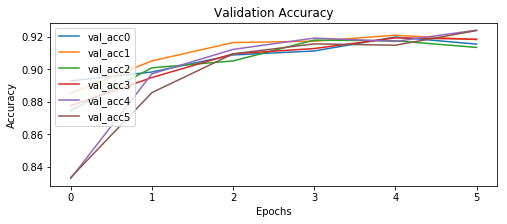

CNN 0: Epochs=6, Train Loss=0.16775, Validation Loss=0.27420
CNN 1: Epochs=6, Train Loss=0.19597, Validation Loss=0.27990
CNN 2: Epochs=6, Train Loss=0.22570, Validation Loss=0.29314
CNN 3: Epochs=6, Train Loss=0.26093, Validation Loss=0.28610
CNN 4: Epochs=6, Train Loss=0.26982, Validation Loss=0.27945
CNN 5: Epochs=6, Train Loss=0.32172, Validation Loss=0.28744


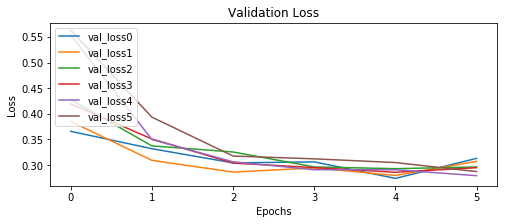

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 4 is the best one
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 32, 32, 40)        400       
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 15, 15, 40)        14440     
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 15, 15, 80)        28880     
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 15, 15, 80)        57680     
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 15, 15, 8

In [0]:
BEST_L2_REG = reg_factor[best]

### Train the model on the whole training set (train + validation renormalized)

In [0]:
#reload the datasets and renormalize them, without splitting the validation set.
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

In [0]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

In [0]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for the test set
test_img = test_img - train_mean
test_img = test_img / train_std

In [0]:
#create the final model
model = models.Sequential()
    
model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
        
model.add(layers.Flatten())
model.add(layers.Dense(fcw, activation='relu'))
model.add(layers.Dropout(best_dropout))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/training/model'
os.makedirs(base_name, exist_ok=True)

#train it
history = model.fit(train_img, train_lbs, batch_size=BEST_BATCH_SIZE, epochs=EPOCH_NUM,
                    validation_data=(test_img, test_lbs),
                    verbose = 1, callbacks=create_callbacks(base_name+str(i), lr=BEST_LR))

In [0]:
save_history([history], base_name)

plot_validation([history])

plot_validation([history], loss=True)

In [0]:
model.evaluate(test_img, test_lbs)